# Aneurysm Simulation VTK Data Processor

This notebook loads .vtk files from aneurysm simulations, extracts the specific fields (rho, velocity, wall shear stress, etc.), and organizes them into dictionaries of NumPy arrays for further analysis and visualization. Each field will be accessible by frame number.

## Import Required Libraries

In [74]:
import os
import numpy as np
import json
import vtk
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import re
import tqdm
import time
from IPython.display import display, clear_output

## Locate VTK Files and Parameters

First, we need to find the 'aneurysm_simulation_results' folder and its subfolders containing VTK files and parameter files.

In [75]:
# Define the base directory where the simulation results are located
base_dir = Path('/home/abdua786/code/uni/3/dissertation/dissertation')
simulation_folder = base_dir / 'aneurysm_simulation_results'

# Check if the simulation folder exists
if not simulation_folder.exists():
    print(f"Error: Simulation folder not found at {simulation_folder}")
else:
    print(f"Found simulation folder at: {simulation_folder}")
    
    # Define paths to the VTK files, parameter files, and images
    vtk_folder = simulation_folder / 'vtk'
    params_folder = simulation_folder / 'parameters'
    images_folder = simulation_folder / 'images'
    
    # Check if each subfolder exists
    folders_status = {
        "VTK files": vtk_folder.exists(),
        "Parameter files": params_folder.exists(),
        "Image files": images_folder.exists()
    }
    
    for folder_type, exists in folders_status.items():
        status = "✓ Found" if exists else "✗ Not found"
        print(f"{status}: {folder_type}")
    
    # Function to sort VTK files naturally by frame number
    def natural_sort_key(s):
        """Sort strings with embedded numbers naturally"""
        return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', str(s))]
    
    # Get all VTK files and sort them
    if vtk_folder.exists():
        vtk_files = sorted(list(vtk_folder.glob('*.vtk')), key=natural_sort_key)
        print(f"\nFound {len(vtk_files)} VTK files")
        
        # Display some example filenames
        if vtk_files:
            print("Example VTK files:")
            for file in vtk_files[:5]:  # Show first 5 files
                print(f"- {file.name}")
            if len(vtk_files) > 5:
                print(f"... and {len(vtk_files) - 5} more files")
    
    # Get all parameter files
    if params_folder.exists():
        param_files = list(params_folder.glob('*.json'))
        print(f"\nFound {len(param_files)} parameter files")
        
        # Display some example filenames
        if param_files:
            print("Example parameter files:")
            for file in param_files[:3]:  # Show up to 3 files
                print(f"- {file.name}")

Found simulation folder at: /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results
✓ Found: VTK files
✓ Found: Parameter files
✓ Found: Image files

Found 101 VTK files
Example VTK files:
- aneurysm_0100000.vtk
- aneurysm_0101000.vtk
- aneurysm_0102000.vtk
- aneurysm_0103000.vtk
- aneurysm_0104000.vtk
... and 96 more files

Found 1 parameter files
Example parameter files:
- aneurysm_params 11:54:49 06-05-2025.json


## Load Simulation Parameters

Let's load the simulation parameters from the JSON files to understand the simulation settings.

In [76]:
def load_parameters(param_files):
    """Load and parse parameter files"""
    parameters = {}
    
    if not param_files:
        print("No parameter files to load")
        return parameters
    
    for file_path in param_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                # Use the filename as the key
                parameters[file_path.stem] = data
        except Exception as e:
            print(f"Error loading {file_path.name}: {e}")
    
    return parameters

# Load the parameters if parameter files were found
if 'param_files' in locals() and param_files:
    sim_parameters = load_parameters(param_files)
    
    # Display the parameters in a structured way
    if sim_parameters:
        print(f"Loaded {len(sim_parameters)} parameter files successfully")
        
        # Display parameters from the first file as an example
        first_param_file = next(iter(sim_parameters))
        params = sim_parameters[first_param_file]
        
        print(f"\nParameters from {first_param_file}:")
        # Group parameters by category if they follow a standard format
        # Otherwise, display the top-level parameters
        for key, value in params.items():
            # If the value is a dictionary, show it in a compact form
            if isinstance(value, dict):
                print(f"- {key}: {len(value)} parameters")
            elif isinstance(value, list) and len(value) > 5:
                print(f"- {key}: list with {len(value)} items")
            else:
                print(f"- {key}: {value}")
else:
    print("No parameter files available")
    sim_parameters = {}

Loaded 1 parameter files successfully

Parameters from aneurysm_params 11:54:49 06-05-2025:
- input_parameters: 16 parameters
- physical: 8 parameters
- numerical: 9 parameters
- metadata: 3 parameters
- performance: 3 parameters


## Read and Extract Fields from VTK Files

Now we'll create functions to extract the specific fields from the VTK files. Based on the sample VTK file analysis, we know we need to extract: rho, u_x, u_y, u_magnitude, wss_magnitude, wss_x, wss_y, and wall_mask.

In [77]:
def extract_frame_number(filename):
    """Extract the frame number from the VTK filename"""
    # Extract all digits from the filename
    digits = ''.join(re.findall(r'\d+', filename))
    if digits:
        return int(digits)
    return None

def read_vtk_file(file_path):
    """Read a VTK file and return the data object"""
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(str(file_path))
    reader.Update()
    return reader.GetOutput()

def extract_vtk_fields(vtk_data):
    """Extract all fields from a VTK data object"""
    fields = {}
    
    # Extract cell data (where most of our fields are located)
    cell_data = vtk_data.GetCellData()
    num_arrays = cell_data.GetNumberOfArrays()
    
    for i in range(num_arrays):
        array_name = cell_data.GetArrayName(i)
        vtk_array = cell_data.GetArray(array_name)
        numpy_array = numpy_support.vtk_to_numpy(vtk_array)
        fields[array_name] = numpy_array
    
    # Extract point data (if any)
    point_data = vtk_data.GetPointData()
    num_point_arrays = point_data.GetNumberOfArrays()
    
    for i in range(num_point_arrays):
        array_name = point_data.GetArrayName(i)
        vtk_array = point_data.GetArray(array_name)
        numpy_array = numpy_support.vtk_to_numpy(vtk_array)
        fields[f"point_{array_name}"] = numpy_array
    
    # Store dimensions for future reference
    dims = vtk_data.GetDimensions()
    fields['dimensions'] = np.array(dims)
    
    return fields

# Test the extraction functions on the first VTK file
if 'vtk_files' in locals() and vtk_files:
    test_file = vtk_files[0]
    print(f"Testing field extraction on {test_file.name}...")
    
    try:
        vtk_data = read_vtk_file(test_file)
        fields = extract_vtk_fields(vtk_data)
        
        print("\nExtracted fields:")
        for field_name, field_data in fields.items():
            if field_name != 'dimensions':
                print(f"- {field_name}: shape {field_data.shape}, type {field_data.dtype}, "  
                      f"range [{field_data.min():.6f}, {field_data.max():.6f}]")
            else:
                print(f"- {field_name}: {field_data}")
        
        # Extract frame number for reference
        frame_num = extract_frame_number(test_file.name)
        print(f"\nFrame number: {frame_num}")
        
    except Exception as e:
        print(f"Error reading {test_file.name}: {e}")

Testing field extraction on aneurysm_0100000.vtk...

Extracted fields:
- rho: shape (395472,), type float32, range [0.644305, 1.000000]
- u_x: shape (395472,), type float32, range [-0.160970, 0.109950]
- u_y: shape (395472,), type float32, range [-0.050631, 0.132450]
- u_magnitude: shape (395472,), type float32, range [0.000000, 0.160973]
- wss_magnitude: shape (395472,), type float64, range [0.000000, 7.005581]
- wss_x: shape (395472,), type float64, range [-0.407203, 0.914827]
- wss_y: shape (395472,), type float64, range [-0.178038, 0.914827]
- wall_mask: shape (395472,), type int32, range [0.000000, 1.000000]
- dimensions: [750 529   1]

Frame number: 100000


## Process All VTK Files and Organize as Dictionaries

Now we'll process all the VTK files and organize the extracted fields into dictionaries keyed by frame number.

In [78]:
def process_all_vtk_files(vtk_files, max_files=None):
    """Process all VTK files and organize their fields by name and frame"""
    # Initialize dictionaries to store each field
    field_data = {}
    frame_numbers = []
    
    # Limit the number of files to process if specified
    if max_files is not None and max_files > 0:
        vtk_files = vtk_files[:max_files]
    
    # Process each VTK file
    for file_path in tqdm.tqdm(vtk_files, desc="Processing VTK files"):
        try:
            # Extract frame number from filename
            frame_num = extract_frame_number(file_path.name)
            if frame_num is None:
                continue
                
            frame_numbers.append(frame_num)
            
            # Read and extract fields
            vtk_data = read_vtk_file(file_path)
            fields = extract_vtk_fields(vtk_data)
            
            # Organize fields by name, with frames stored sequentially
            for field_name, field_array in fields.items():
                if field_name not in field_data:
                    field_data[field_name] = {}
                
                field_data[field_name][frame_num] = field_array
                
        except Exception as e:
            print(f"Error processing {file_path.name}: {e}")
    
    # Get list of unique field names
    all_fields = list(field_data.keys())
    print(f"\nProcessed {len(frame_numbers)} VTK files with {len(all_fields)} fields per file")
    print(f"Field names: {', '.join(all_fields)}")
    
    return field_data, sorted(frame_numbers)

# Process a subset of files for demonstration
# Set this to None to process all files
max_files_to_process = None

# Process the VTK files
if 'vtk_files' in locals() and vtk_files:
    print(f"Processing VTK files...")
    if max_files_to_process:
        print(f"Limiting to {max_files_to_process} files for demonstration")
    
    # Process the files
    vtk_field_data, frame_numbers = process_all_vtk_files(vtk_files, max_files_to_process)
    
    # Print information about the processed data
    print(f"\nProcessed frames: {min(frame_numbers)} to {max(frame_numbers)}")
    
    # Check data dimensions
    for field_name, frames_data in vtk_field_data.items():
        if field_name != 'dimensions':
            # Get the shape of the first frame's data
            first_frame = frames_data[frame_numbers[0]]
            print(f"Field '{field_name}': {len(frames_data)} frames, shape per frame: {first_frame.shape}")
else:
    print("No VTK files to process")

Processing VTK files...


Processing VTK files: 100%|██████████| 101/101 [00:06<00:00, 14.73it/s]



Processed 101 VTK files with 9 fields per file
Field names: rho, u_x, u_y, u_magnitude, wss_magnitude, wss_x, wss_y, wall_mask, dimensions

Processed frames: 100000 to 200000
Field 'rho': 101 frames, shape per frame: (395472,)
Field 'u_x': 101 frames, shape per frame: (395472,)
Field 'u_y': 101 frames, shape per frame: (395472,)
Field 'u_magnitude': 101 frames, shape per frame: (395472,)
Field 'wss_magnitude': 101 frames, shape per frame: (395472,)
Field 'wss_x': 101 frames, shape per frame: (395472,)
Field 'wss_y': 101 frames, shape per frame: (395472,)
Field 'wall_mask': 101 frames, shape per frame: (395472,)


## Stack Fields into 3D NumPy Arrays

Let's create 3D arrays by stacking all frames for each field. This will allow for easier indexing by frame number.

In [79]:
def stack_fields_into_arrays(field_data, frame_numbers):
    """Stack all frames for each field into 3D NumPy arrays"""
    stacked_fields = {}
    
    for field_name, frames_data in field_data.items():
        if field_name == 'dimensions':
            # Just store one copy of the dimensions
            stacked_fields[field_name] = next(iter(frames_data.values()))
            continue
        
        # Check if all frames have the same shape
        shapes = {frame: data.shape for frame, data in frames_data.items()}
        if len(set(shapes.values())) > 1:
            print(f"Warning: Field '{field_name}' has inconsistent shapes across frames")
            stacked_fields[field_name] = frames_data  # Store as dictionary
            continue
        
        # All frames have the same shape, stack them into a 3D array
        try:
            # Create arrays in order of frame numbers
            sorted_frames = sorted(frames_data.keys())
            arrays_to_stack = [frames_data[frame] for frame in sorted_frames]
            
            # Stack along a new first dimension (frame)
            stacked_array = np.stack(arrays_to_stack, axis=0)
            
            # Store the stacked array and frame mapping
            stacked_fields[field_name] = stacked_array
            
            print(f"Stacked '{field_name}' into array with shape {stacked_array.shape}")
            
        except Exception as e:
            print(f"Error stacking {field_name}: {e}")
            # If stacking fails, store as a dictionary
            stacked_fields[field_name] = frames_data
    
    # Create a mapping from frame numbers to indices
    frame_to_index = {frame: i for i, frame in enumerate(sorted(frame_numbers))}
    
    return stacked_fields, frame_to_index

# Stack the fields if field data is available
if 'vtk_field_data' in locals() and vtk_field_data:
    print("Stacking fields into 3D arrays...")
    
    # Stack the fields
    stacked_fields, frame_to_index = stack_fields_into_arrays(vtk_field_data, frame_numbers)
    
    # Print information about the stacked data
    print("\nStacked fields:")
    for field_name, field_array in stacked_fields.items():
        if isinstance(field_array, np.ndarray):
            if field_name != 'dimensions':
                print(f"- {field_name}: shape {field_array.shape}, type {field_array.dtype}, "  
                      f"memory usage {field_array.nbytes / (1024**2):.2f} MB")
            else:
                print(f"- {field_name}: {field_array}")
        else:
            print(f"- {field_name}: dictionary with {len(field_array)} frames")
    
    # Create a utility function to get data for a specific frame
    def get_frame_data(field_name, frame_number):
        """Get data for a specific field and frame number"""
        if field_name not in stacked_fields:
            print(f"Field '{field_name}' not found")
            return None
        
        field_data = stacked_fields[field_name]
        
        if isinstance(field_data, dict):
            # Dictionary storage
            if frame_number in field_data:
                return field_data[frame_number]
            else:
                print(f"Frame {frame_number} not found for field '{field_name}'")
                return None
        elif isinstance(field_data, np.ndarray) and field_name != 'dimensions':
            # Array storage - look up the index
            if frame_number in frame_to_index:
                index = frame_to_index[frame_number]
                return field_data[index]
            else:
                print(f"Frame {frame_number} not found in frame mapping")
                return None
        else:
            # Dimensions or other non-frame data
            return field_data
    
    # Print example usage
    print("\nExample usage:")
    print("stacked_fields['rho'] - Gets the 3D array with all density data")
    print("get_frame_data('rho', 100000) - Gets density data for frame 100000")

    print("\nExample frame data:")
    example_frame_data = get_frame_data('rho', 100000)
    if example_frame_data is not None:
        print(f"Density data for frame 100000: shape {example_frame_data.shape}, type {example_frame_data.dtype}")
else:
    print("No field data available to stack")

Stacking fields into 3D arrays...
Stacked 'rho' into array with shape (101, 395472)
Stacked 'u_x' into array with shape (101, 395472)
Stacked 'u_y' into array with shape (101, 395472)
Stacked 'u_magnitude' into array with shape (101, 395472)
Stacked 'wss_magnitude' into array with shape (101, 395472)
Stacked 'wss_x' into array with shape (101, 395472)
Stacked 'wss_y' into array with shape (101, 395472)
Stacked 'wall_mask' into array with shape (101, 395472)

Stacked fields:
- rho: shape (101, 395472), type float32, memory usage 152.37 MB
- u_x: shape (101, 395472), type float32, memory usage 152.37 MB
- u_y: shape (101, 395472), type float32, memory usage 152.37 MB
- u_magnitude: shape (101, 395472), type float32, memory usage 152.37 MB
- wss_magnitude: shape (101, 395472), type float64, memory usage 304.74 MB
- wss_x: shape (101, 395472), type float64, memory usage 304.74 MB
- wss_y: shape (101, 395472), type float64, memory usage 304.74 MB
- wall_mask: shape (101, 395472), type int32


# Reshaping Fields for Visualization

This cell reshapes the extracted 1D field data into 2D arrays based on the simulation grid dimensions. It also applies orientation corrections, such as vertical flips, to ensure the data is properly aligned for visualization. The reshaped fields are stored in a new dictionary for further analysis and visualization.


Reshaping all fields to 2D arrays...
Reshaping fields to dimensions: (528, 749)
Reshaping field: rho
Reshaping field: u_x
Reshaping field: u_y
Reshaping field: u_magnitude
Reshaping field: wss_magnitude
Reshaping field: wss_x
Reshaping field: wss_y
Reshaping field: wall_mask
Reshaped 8 fields (excluding dimensions)

Applying vertical flip orientation correction to reshaped data...
Orientation correction applied to all reshaped fields

Reshaped 2D fields:
- dimensions: shape (3,), type int64
- rho: shape (101, 528, 749), type float32
- u_x: shape (101, 528, 749), type float32
- u_y: shape (101, 528, 749), type float32
- u_magnitude: shape (101, 528, 749), type float32
- wss_magnitude: shape (101, 528, 749), type float64
- wss_x: shape (101, 528, 749), type float64
- wss_y: shape (101, 528, 749), type float64
- wall_mask: shape (101, 528, 749), type int32

Example of reshaped data:

rho data for frame 100000:


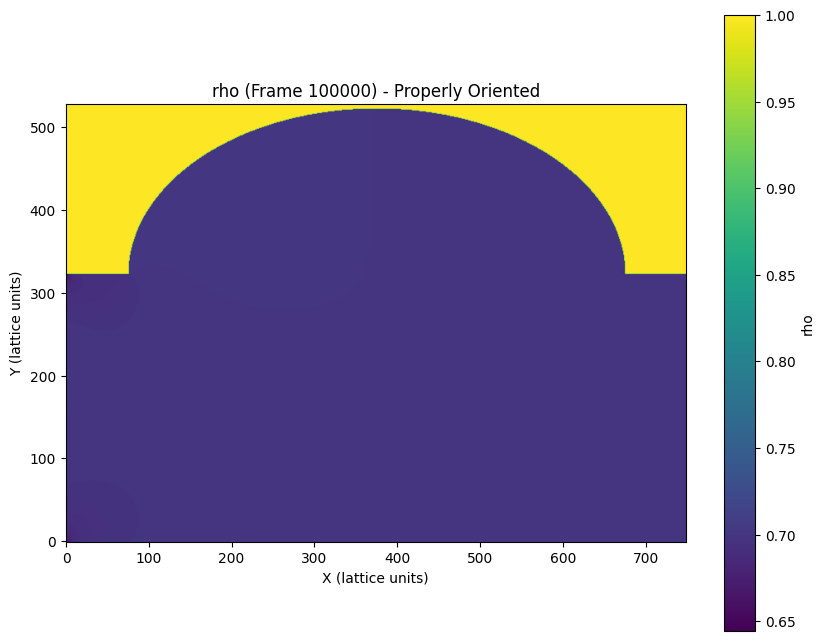

Shape: (528, 749)
Min: 0.644305, Max: 1.000000
Mean: 0.744543, Std: 0.107511

u_magnitude data for frame 100000:


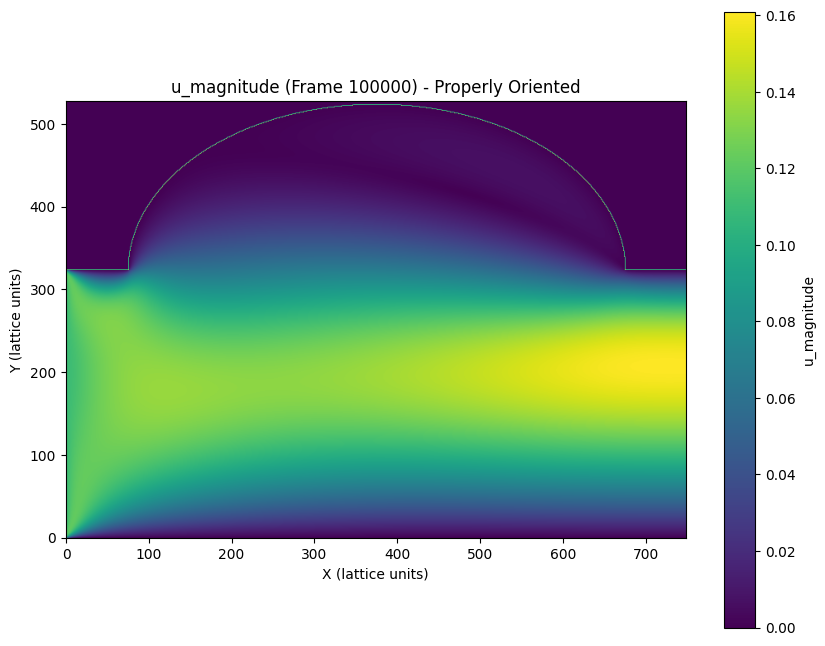

Shape: (528, 749)
Min: 0.000000, Max: 0.160973
Mean: 0.066974, Std: 0.055035


In [80]:
# Add this cell after the data loading and before visualization
def reshape_all_fields_to_2d(stacked_fields, frame_to_index=None):
    """
    Reshape all 1D field data into 2D arrays for easier analysis and visualization.
    Returns a new dictionary with reshaped data.
    """
    if 'dimensions' not in stacked_fields:
        print("Dimensions not available for reshaping data")
        return stacked_fields
    
    # Get dimensions for reshaping
    dimensions = stacked_fields['dimensions']
    real_dims = [d for d in dimensions if d > 1]
    
    if len(real_dims) < 2:
        print("Cannot reshape data - insufficient dimensions")
        return stacked_fields
    
    # Dimensions for reshaping - need to subtract 1 because VTK dimensions are cell counts + 1
    ny, nx = real_dims[1]-1, real_dims[0]-1
    print(f"Reshaping fields to dimensions: ({ny}, {nx})")
    
    # Create a new dictionary to store the reshaped fields
    reshaped_fields = {'dimensions': stacked_fields['dimensions']}
    
    # Process each field
    for field_name, field_data in stacked_fields.items():
        if field_name == 'dimensions':
            continue
            
        print(f"Reshaping field: {field_name}")
        
        # Handle 3D arrays (stacked frames)
        if isinstance(field_data, np.ndarray) and field_data.ndim > 1:
            # Get the number of frames
            n_frames = field_data.shape[0]
            
            # Create a new array with reshaped dimensions
            reshaped_array = np.zeros((n_frames, ny, nx), dtype=field_data.dtype)
            
            # Reshape each frame
            for i in range(n_frames):
                frame_data = field_data[i]
                # Reshape the 1D array to 2D
                try:
                    reshaped_array[i] = np.flipud(frame_data.reshape(ny, nx))
                except Exception as e:
                    print(f"Error reshaping frame {i} for {field_name}: {e}")
                    # Keep original data if reshaping fails
                    reshaped_array[i] = frame_data
            
            # Store the reshaped array
            reshaped_fields[field_name] = reshaped_array
            
        # Handle dictionary of frames
        elif isinstance(field_data, dict):
            reshaped_dict = {}
            
            # Reshape each frame in the dictionary
            for frame_num, frame_data in field_data.items():
                try:
                    reshaped_dict[frame_num] = frame_data.reshape(ny, nx)
                except Exception as e:
                    print(f"Error reshaping frame {frame_num} for {field_name}: {e}")
                    # Keep original data if reshaping fails
                    reshaped_dict[frame_num] = frame_data
            
            # Store the reshaped dictionary
            reshaped_fields[field_name] = reshaped_dict
            
        # Handle single arrays (not per-frame)
        elif isinstance(field_data, np.ndarray) and field_data.ndim == 1 and field_name != 'dimensions':
            try:
                reshaped_fields[field_name] = field_data.reshape(ny, nx)
            except Exception as e:
                print(f"Error reshaping {field_name}: {e}")
                # Keep original data if reshaping fails
                reshaped_fields[field_name] = field_data
        else:
            # For any other type of data, keep as is
            reshaped_fields[field_name] = field_data
    
    print(f"Reshaped {len(reshaped_fields)-1} fields (excluding dimensions)")
    
    # Apply vertical flip correction to the reshaped data
    print("\nApplying vertical flip orientation correction to reshaped data...")
    corrected_fields = {'dimensions': reshaped_fields['dimensions']}
    
    for field_name, field_data in reshaped_fields.items():
        if field_name == 'dimensions':
            continue
            
        # Handle 3D arrays (stacked frames)
        if isinstance(field_data, np.ndarray) and field_data.ndim == 3:
            # Create a new array with the same shape
            corrected_array = np.zeros_like(field_data)
            
            # Flip each frame
            for i in range(field_data.shape[0]):
                # Apply vertical flip
                corrected_array[i] = np.flipud(field_data[i])
                
                # Negate velocity components if needed
                if field_name in ['u_x', 'wss_x']:
                    corrected_array[i] = -corrected_array[i]
            
            corrected_fields[field_name] = corrected_array
            
        # Handle dictionary of frames
        elif isinstance(field_data, dict):
            corrected_dict = {}
            
            for frame_num, frame_data in field_data.items():
                if frame_data.ndim == 2:  # Only process 2D arrays
                    corrected = np.flipud(frame_data)
                    
                    # Negate velocity components if needed
                    if field_name in ['u_x', 'wss_x']:
                        corrected = -corrected
                        
                    corrected_dict[frame_num] = corrected
                else:
                    corrected_dict[frame_num] = frame_data
            
            corrected_fields[field_name] = corrected_dict
            
        # Handle 2D arrays (single frame)
        elif isinstance(field_data, np.ndarray) and field_data.ndim == 2:
            corrected = np.flipud(field_data)
            
            # Negate velocity components if needed
            if field_name in ['u_x', 'wss_x']:
                corrected = -corrected
                
            corrected_fields[field_name] = corrected
        else:
            # For any other type of data, keep as is
            corrected_fields[field_name] = field_data
    
    print("Orientation correction applied to all reshaped fields")
    
    return corrected_fields

# Apply the reshaping function if the stacked fields are available
if 'stacked_fields' in locals() and stacked_fields:
    print("Reshaping all fields to 2D arrays...")
    
    # Reshape the fields
    reshaped_fields = reshape_all_fields_to_2d(stacked_fields, frame_to_index)
    
    # Print information about the reshaped data
    print("\nReshaped 2D fields:")
    for field_name, field_data in reshaped_fields.items():
        if isinstance(field_data, np.ndarray):
            print(f"- {field_name}: shape {field_data.shape}, type {field_data.dtype}")
        else:
            print(f"- {field_name}: {type(field_data).__name__}")
    
    # Create a utility function to get frame data from reshaped fields
    def get_reshaped_frame(field_name, frame_number):
        """Get 2D data for a specific field and frame number from the reshaped fields"""
        if field_name not in reshaped_fields:
            print(f"Field '{field_name}' not found")
            return None
        
        field_data = reshaped_fields[field_name]
        
        if isinstance(field_data, dict):
            # Dictionary storage
            if frame_number in field_data:
                return field_data[frame_number]
            else:
                print(f"Frame {frame_number} not found for field '{field_name}'")
                return None
        elif isinstance(field_data, np.ndarray) and field_data.ndim == 3:
            # 3D Array storage (frames, ny, nx) - look up the index
            if frame_to_index and frame_number in frame_to_index:
                index = frame_to_index[frame_number]
                return field_data[index]
            else:
                print(f"Frame {frame_number} not found in frame mapping")
                return None
        else:
            # 2D data or other non-frame data
            return field_data
    
    # Display a couple of examples of the reshaped data
    if frame_numbers:
        print("\nExample of reshaped data:")
        example_frame = frame_numbers[0]
        for field in ['rho', 'u_magnitude']:
            if field in reshaped_fields:
                frame_data = get_reshaped_frame(field, example_frame)
                if frame_data is not None and isinstance(frame_data, np.ndarray) and frame_data.ndim == 2:
                    print(f"\n{field} data for frame {example_frame}:")
                    plt.figure(figsize=(10, 8))
                    plt.imshow(frame_data, cmap='viridis', origin='lower')
                    plt.colorbar(label=field)
                    plt.title(f"{field} (Frame {example_frame}) - Properly Oriented")
                    plt.xlabel('X (lattice units)')
                    plt.ylabel('Y (lattice units)')
                    plt.show()
                    
                    # Print some statistics
                    print(f"Shape: {frame_data.shape}")
                    print(f"Min: {frame_data.min():.6f}, Max: {frame_data.max():.6f}")
                    print(f"Mean: {frame_data.mean():.6f}, Std: {frame_data.std():.6f}")
else:
    print("No stacked fields available for reshaping")

## Save the Processed Data

Let's save the processed data for future use. We'll save it in a compressed NumPy format.

In [81]:
def save_stacked_fields_as_npz(stacked_fields, frame_to_index, output_dir=None):
    """
    Save each field from stacked_fields as individual .npz files without reshaping.
    
    Args:
        stacked_fields: Dictionary containing the field data
        frame_to_index: Dictionary mapping frame numbers to indices
        output_dir: Directory where files will be saved (created if it doesn't exist)
    
    Returns:
        Dictionary mapping field names to saved file paths
    """
    import os
    import numpy as np
    from pathlib import Path
    import time
    
    # Create output directory if not specified
    if output_dir is None:
        base_dir = Path('/home/abdua786/code/uni/3/dissertation/dissertation')
        simulation_folder = base_dir / 'aneurysm_simulation_results'
        if simulation_folder.exists():
            output_dir = simulation_folder / 'processed_data' / 'raw_fields'
        else:
            # Fallback
            output_dir = base_dir / 'processed_data' / 'raw_fields'
    else:
        output_dir = Path(output_dir)
    
    # Create directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Saving stacked fields to {output_dir}")
    
    # Convert frame_to_index to arrays for storage
    frame_numbers = np.array(list(frame_to_index.keys()))
    frame_indices = np.array(list(frame_to_index.values()))
    
    # Save frame mapping for reference
    frame_mapping_file = output_dir / 'frame_mapping.npz'
    np.savez_compressed(
        frame_mapping_file, 
        frame_numbers=frame_numbers, 
        frame_indices=frame_indices
    )
    print(f"Saved frame mapping to {frame_mapping_file}")
    
    # Store paths of saved files
    saved_files = {'frame_mapping': frame_mapping_file}
    
    # Save each field as a separate npz file
    for field_name, field_data in stacked_fields.items():
        if isinstance(field_data, np.ndarray):
            # Create filename based on field name
            output_file = output_dir / f"{field_name}.npz"
            
            # Save as compressed npz file - each field gets its own file
            np.savez_compressed(output_file, data=field_data)
            
            # Record file size for reporting
            file_size = os.path.getsize(output_file) / (1024**2)  # size in MB
            saved_files[field_name] = output_file
            
            print(f"Saved field '{field_name}' to {output_file} ({file_size:.2f} MB)")
        else:
            print(f"Skipping field '{field_name}' as it's not a NumPy array")
    
    # Create a README file with information about the data
    readme_path = output_dir / "README.txt"
    with open(readme_path, 'w') as f:
        f.write("Aneurysm Simulation Raw Field Data\n")
        f.write("===============================\n\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of frames: {len(frame_numbers)}\n")
        f.write("\nAvailable fields:\n")
        
        for field_name in stacked_fields.keys():
            if field_name in saved_files:
                field_data = stacked_fields[field_name]
                if isinstance(field_data, np.ndarray):
                    shape_str = str(field_data.shape)
                    f.write(f"- {field_name}: {shape_str}\n")
        
        f.write("\nNotes:\n")
        f.write("- These files contain the raw field data without reshaping\n")
        f.write("- The frame_mapping.npz file contains the mapping between frame numbers and indices\n")
        f.write("- Each field is stored as a separate .npz file for easier loading\n")
        f.write("- To load a field: data = np.load('field_name.npz')['data']\n")
    
    print(f"\nSaved {len(saved_files)-1} fields to {output_dir}")
    print(f"Created README at {readme_path}")
    
    return saved_files

# Run the function if stacked_fields are available
if 'stacked_fields' in locals() and stacked_fields:
    print("Saving stacked fields as individual .npz files without reshaping...")
    saved_files = save_stacked_fields_as_npz(stacked_fields, frame_to_index)
    
    # Provide example code for loading the data
    print("\nTo load these files in another script, use:")
    print("```python")
    print("import numpy as np")
    print("from pathlib import Path")
    print()
    print("# Set the data directory")
    print("data_dir = Path('/path/to/processed_data/raw_fields')")
    print()
    print("# Load frame mapping")
    print("frame_mapping = np.load(data_dir / 'frame_mapping.npz')")
    print("frame_numbers = frame_mapping['frame_numbers']")
    print("frame_indices = frame_mapping['frame_indices']")
    print()
    print("# Load a specific field (e.g., 'rho')")
    print("rho_data = np.load(data_dir / 'rho.npz')['data']")
    print()
    print("# To get data for a specific frame (e.g., frame 100000)")
    print("frame_num = 100000")
    print("frame_idx = np.where(frame_numbers == frame_num)[0][0]")
    print("rho_frame_data = rho_data[frame_idx]")
    print("```")
else:
    print("No stacked field data available to save")

Saving stacked fields as individual .npz files without reshaping...
Saving stacked fields to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields
Saved frame mapping to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/frame_mapping.npz
Saved field 'rho' to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/rho.npz (69.70 MB)
Saved field 'u_x' to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/u_x.npz (108.89 MB)
Saved field 'u_y' to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/u_y.npz (119.33 MB)
Saved field 'u_magnitude' to /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/processed_data/raw_fields/u_magnitude.npz (108.48 MB)
Saved field 'wss_magnitude' to /home/abdua786/code/

To load these files in another script, use:
```python
import numpy as np
from pathlib import Path

# Set the data directory
data_dir = Path('/path/to/processed_data/raw_fields')

# Load frame mapping
frame_mapping = np.load(data_dir / 'frame_mapping.npz')
frame_numbers = frame_mapping['frame_numbers']
frame_indices = frame_mapping['frame_indices']

# Load a specific field (e.g., 'rho')
rho_data = np.load(data_dir / 'rho.npz')['data']

# To get data for a specific frame (e.g., frame 100000)
frame_num = 100000
frame_idx = np.where(frame_numbers == frame_num)[0][0]
rho_frame_data = rho_data[frame_idx]
```

## Verify the Orientation Correction

Let's add a cell to visualize the original data alongside the orientation-corrected data to confirm the fix works.

## Summary

This notebook has processed the aneurysm simulation VTK files and organized them into structured arrays for further analysis. The key outputs are:

1. **Dictionary of field data**: Organized by field name and frame number, allowing access to any field at any frame
2. **Memory-efficient 3D arrays**: All frames for each field are stacked into a single NumPy array for efficient processing
3. **Frame mapping**: Easy lookup from frame numbers to array indices
4. **Saved data**: Processed data saved in:
   - Compressed NPZ file for efficient storage
   - Individual NumPy (.npy) files for easy loading of specific fields
   - All data correctly oriented (fixing the 180° rotation issue)

The processed data can now be used for various analyses, including:

- Tracking changes in density, velocity, or wall shear stress over time
- Creating animations of the simulation results
- Analyzing the relationship between different fields
- Developing machine learning models to predict simulation outcomes


Verifying orientation correction for key fields:

Testing orientation correction for rho:


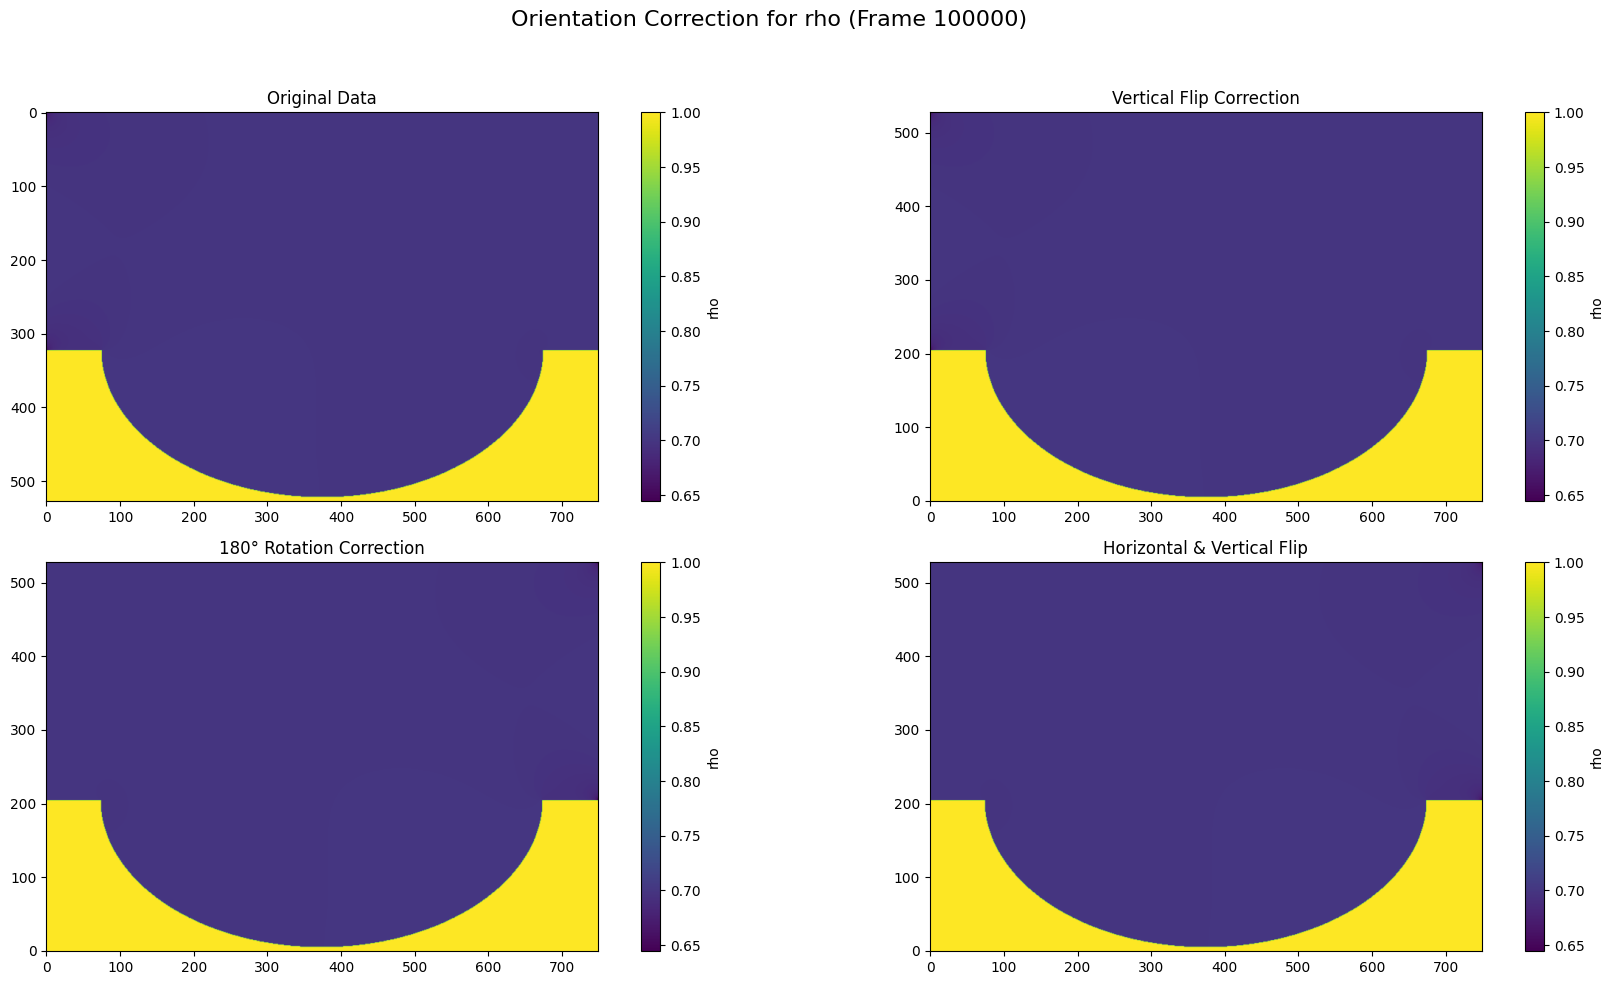

Data dimensions: Original shape (528, 749)
Original data min/max: 0.644305/1.000000
Rotated data min/max: 0.644305/1.000000

Testing orientation correction for u_x:


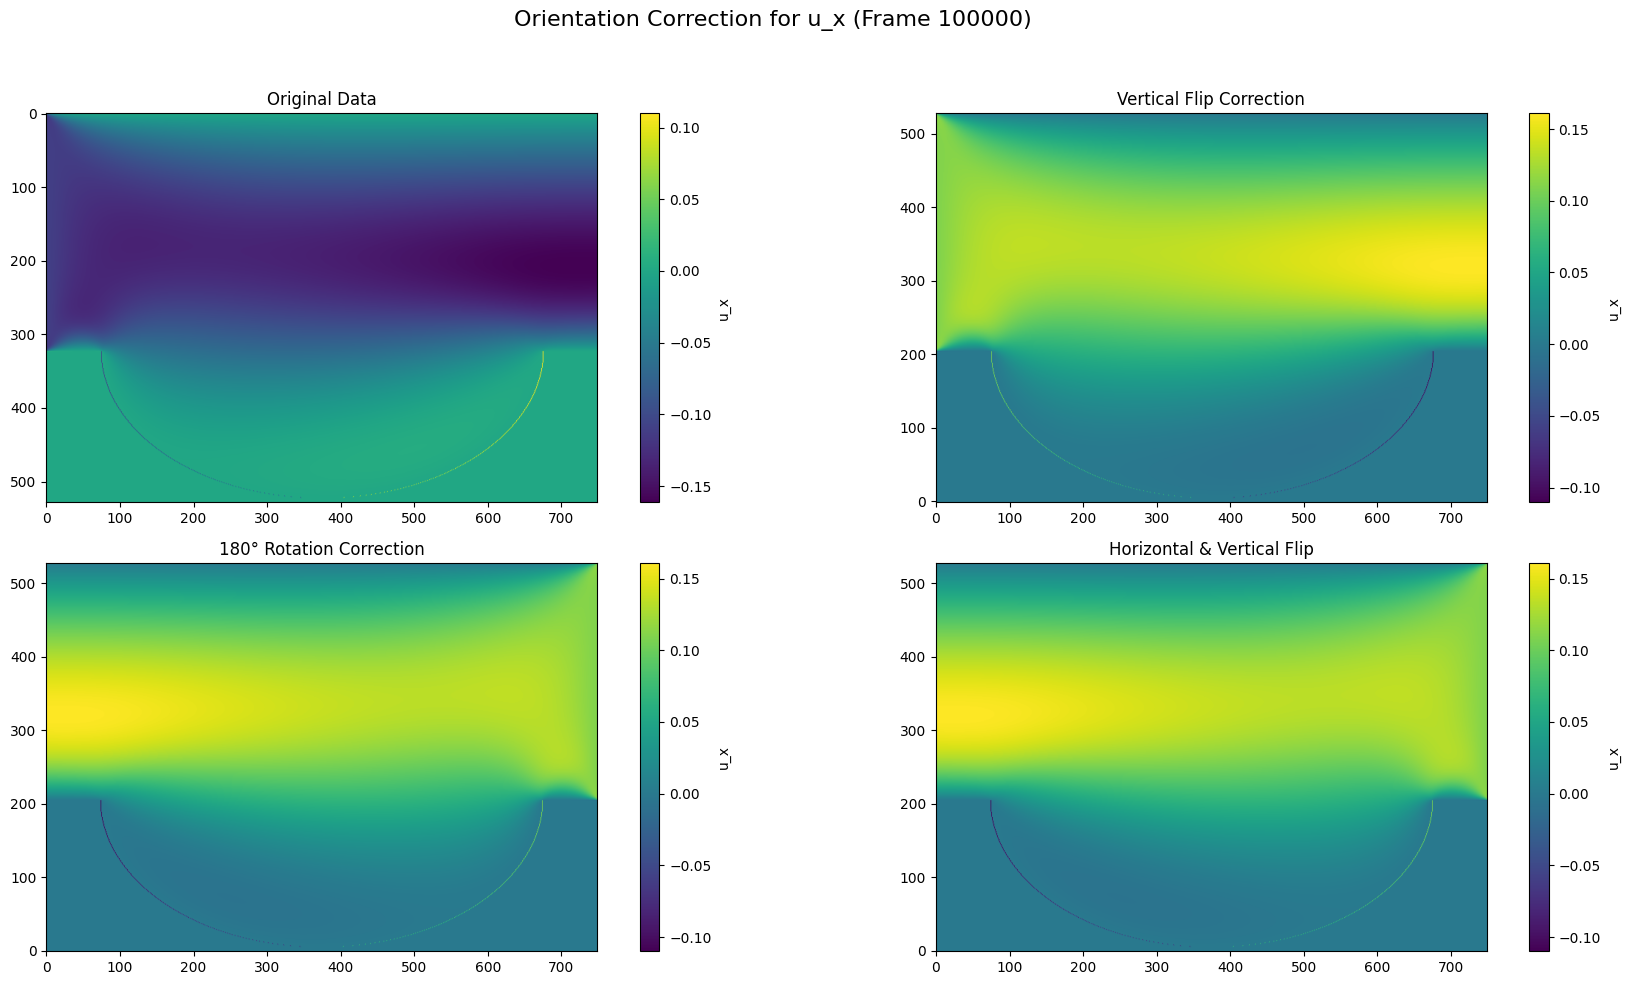

Data dimensions: Original shape (528, 749)
Original data min/max: -0.160970/0.109950
Rotated data min/max: -0.109950/0.160970

Testing orientation correction for u_magnitude:


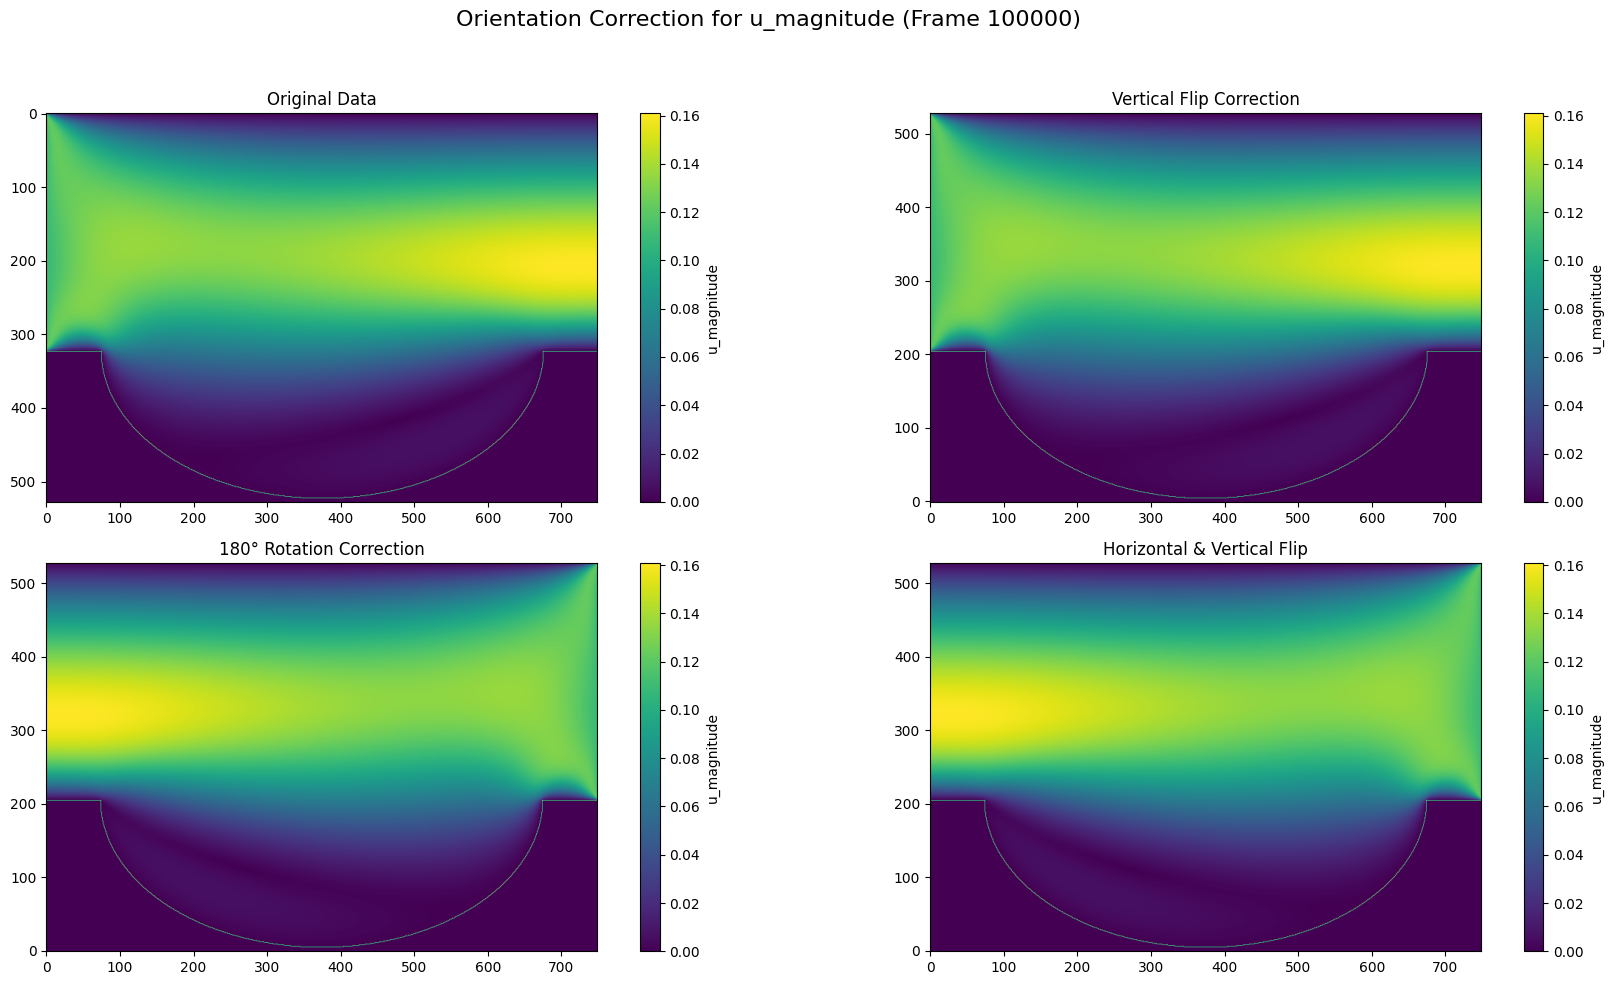

Data dimensions: Original shape (528, 749)
Original data min/max: 0.000000/0.160973
Rotated data min/max: 0.000000/0.160973


In [82]:
def verify_orientation_correction(field_name, frame_number=None, stacked_fields=None, frame_to_index=None):
    



    if stacked_fields is None or field_name not in stacked_fields:
        print(f"Field '{field_name}' not found in the data")
        return
    
    # Get data and dimensions
    if 'dimensions' not in stacked_fields:
        print("Dimensions not available for orientation correction")
        return
    
    dimensions = stacked_fields['dimensions']
    field_data = stacked_fields[field_name]
    
    # Get the frame data
    if frame_number is not None:
        if isinstance(field_data, dict):
            if frame_number in field_data:
                data = field_data[frame_number]
            else:
                print(f"Frame {frame_number} not found for field '{field_name}'")
                return
        elif isinstance(field_data, np.ndarray) and field_name != 'dimensions':
            if frame_to_index and frame_number in frame_to_index:
                index = frame_to_index[frame_number]
                data = field_data[index]
            else:
                print(f"Frame {frame_number} not found in frame mapping")
                return
        else:
            # Non-frame data like dimensions
            data = field_data
    else:
        # If no frame specified and data is a 3D array, use the first frame
        if isinstance(field_data, np.ndarray) and field_data.ndim > 1 and field_name != 'dimensions':
            data = field_data[0]
        else:
            data = field_data
    
    # Skip visualization for dimensions or dictionary data without frame
    if field_name == 'dimensions' or (isinstance(field_data, dict) and frame_number is None):
        print(f"Data for '{field_name}': {data}")
        return
    
    # Create visualization comparing original and corrected data
    plt.figure(figsize=(18, 10))
    

    frame_str = f" (Frame {frame_number})" if frame_number is not None else ""
    plt.suptitle(f"Orientation Correction for {field_name}{frame_str}", fontsize=16)
    
    # Get the real dimensions of the data
    real_dims = [d for d in dimensions if d > 1]
    
    if len(real_dims) < 2 or data.ndim != 1:
        print("Cannot reshape data for visualization")
        return
    
    # Dimensions for reshaping
    ny, nx = real_dims[1]-1, real_dims[0]-1
    
    # Create different visualizations for comparison
    try:
        # 1. Original data
        original = data.reshape(ny, nx)
        plt.subplot(2, 2, 1)
        plt.imshow(original, cmap='viridis')
        plt.colorbar(label=field_name)
        plt.title("Original Data")
        
        # 2. Vertical flip correction
        flipped = np.flipud(original)
        if field_name in ['u_x', 'wss_x']:
            flipped = -flipped
        plt.subplot(2, 2, 2)
        plt.imshow(flipped, cmap='viridis', origin='lower')
        plt.colorbar(label=field_name)
        plt.title("Vertical Flip Correction")
        
        # 3. 180° rotation correction
        rotated = np.rot90(original, k=2)
        if field_name in ['u_x', 'u_y', 'wss_x', 'wss_y']:
            rotated = -rotated
        plt.subplot(2, 2, 3)
        plt.imshow(rotated, cmap='viridis', origin='lower')
        plt.colorbar(label=field_name)
        plt.title("180° Rotation Correction")
        
        # 4. Horizontal & vertical flip (equivalent to 180° rotation)
        hv_flipped = np.flipud(np.fliplr(original))
        if field_name in ['u_x', 'u_y', 'wss_x', 'wss_y']:
            hv_flipped = -hv_flipped
        plt.subplot(2, 2, 4)
        plt.imshow(hv_flipped, cmap='viridis', origin='lower')
        plt.colorbar(label=field_name)
        plt.title("Horizontal & Vertical Flip")
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        # Print some stats for comparison
        print(f"Data dimensions: Original shape {original.shape}")
        print(f"Original data min/max: {original.min():.6f}/{original.max():.6f}")
        print(f"Rotated data min/max: {rotated.min():.6f}/{rotated.max():.6f}")
    except Exception as e:
        print(f"Error during visualization: {e}")

# Run the verification if data is available
if 'stacked_fields' in locals() and stacked_fields and 'frame_numbers' in locals() and frame_numbers:
    print("\nVerifying orientation correction for key fields:")
    
    # Select a frame for testing
    test_frame = frame_numbers[0]
    
    # Test on key fields
    for field in ['rho', 'u_x', 'u_magnitude']:
        if field in stacked_fields:
            print(f"\nTesting orientation correction for {field}:")
            verify_orientation_correction(field, test_frame, stacked_fields, frame_to_index)
else:
    print("No data available for orientation verification")